In [1]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

C:\Users\Admin\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [ ]:
## Read Amazon stocks data from yahoo finance and store it in a csv file
## df_amazon = pdr.get_data_yahoo('AMZN')
## df_amazon.to_csv('Amazon_stocks_price.csv')

In [5]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df_amazon = pd.read_csv('Amazon_stocks_price.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse)

df_amazon.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-04-17,902.380005,887.500000,887.500000,901.989990,2854700,901.989990
2017-04-18,909.609985,900.780029,900.989990,903.780029,2999200,903.780029
2017-04-19,910.500000,897.369995,907.840027,899.200012,2870200,899.200012
2017-04-20,905.320007,896.289978,899.700012,902.059998,2814400,902.059998
2017-04-21,903.650024,896.770020,902.669983,898.530029,2420500,898.530029


In [6]:
df_amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-04-17 to 2022-04-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1260 non-null   float64
 1   Low        1260 non-null   float64
 2   Open       1260 non-null   float64
 3   Close      1260 non-null   float64
 4   Volume     1260 non-null   int64  
 5   Adj Close  1260 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [7]:
df_amazon.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03,1260.000000
mean,2239.636275,2188.709263,2215.748256,2214.463039,4.290618e+06,2214.463039
std,864.505450,842.458122,854.043512,852.776565,2.060588e+06,852.776565
min,902.380005,887.500000,887.500000,898.530029,8.813000e+05,898.530029
25%,1634.937469,1599.757538,1619.474976,1620.460022,2.904150e+06,1620.460022
50%,1908.169983,1872.590027,1891.340027,1889.815002,3.689750e+06,1889.815002
75%,3198.344971,3123.500000,3166.812500,3161.132507,5.075400e+06,3161.132507
max,3773.080078,3696.790039,3744.000000,3731.409912,1.656500e+07,3731.409912


Text(0.5, 1.0, 'Amazon stock price')

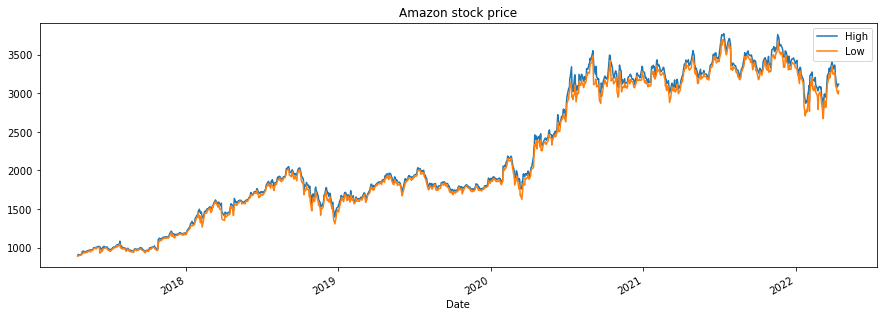

In [8]:
#Stock price
df_amazon[['High','Low']].plot(figsize=(15,5))
plt.title('Amazon stock price')

Text(0.5, 1.0, 'Amazon stock Close price')

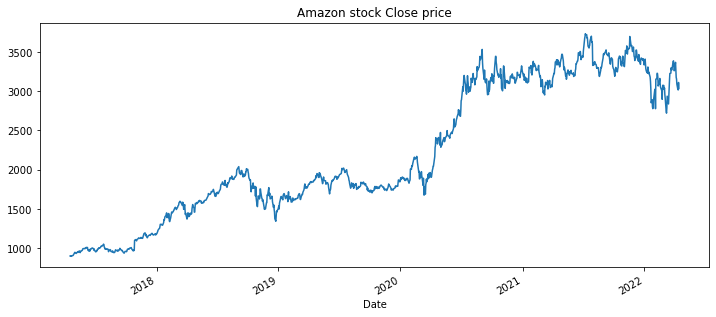

In [9]:
#Stock Close price
df_amazon['Close'].plot(figsize=(12,5))
plt.title('Amazon stock Close price')

## Dickey-fuller test

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
#Test for staionarity
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [12]:
adf_test(df_amazon['Close'])

ADF Statistics: -1.2913002350170035
p- value: 0.63314300834944
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [13]:
#First differencing
df_amazon['Close: First Difference']=df_amazon['Close']-df_amazon['Close'].shift(1)

In [14]:
adf_test(df_amazon['Close: First Difference'].dropna())

ADF Statistics: -22.365803124693123
p- value: 0.0
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
#Stock Close price
df_amazon['Close: First Difference'].plot(figsize=(12,5))
plt.title('Amazon stock Close price - First Difference')

## Plot ACF and PACF

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

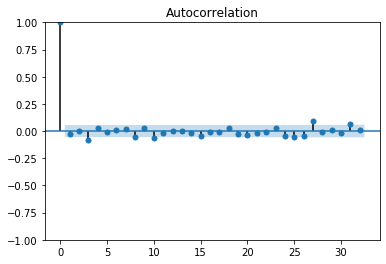

In [17]:
acf = plot_acf(df_amazon['Close: First Difference'].dropna())

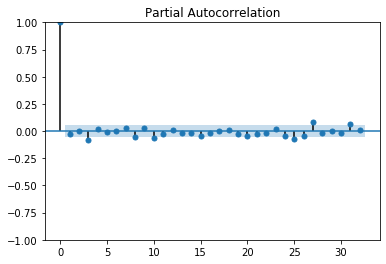

In [18]:
result = plot_pacf(df_amazon['Close: First Difference'].dropna())

## Model building

In [21]:
#split into train and test data
print(df_amazon.shape)

# 70% train data and 30% test data
train = df_amazon.iloc[0:882]
test  = df_amazon.iloc[882:]

print(train.shape, test.shape)

(1260, 7)
(882, 7) (378, 7)


In [22]:
from pmdarima import auto_arima

In [23]:
stepwise_fit = auto_arima(train['Close'], trace=True, test='adf', seasonal=False)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8958.187, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8959.518, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8953.857, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8954.205, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8962.028, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8955.374, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8954.342, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8956.329, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8957.292, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.517 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  882
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4473.928
Date:                Sat, 16 Apr 2022   AIC                           8953.857
Time:                        19:36:20   BIC                           8968.200
Sample:                             0   HQIC                          8959.341
                                - 882                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0650      1.318      2.326      0.020       0.482       5.648
ar.L1         -0.0932      0.021     -4.355      0.000      -0.135      -0.051
sigma2      1509.7864     39.760     37.972      0.000    1431.858    1587.715
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               792.25
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               7.01   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
'''
from statsmodels.tsa.arima_model import ARIMA
model       = ARIMA(df_amazon['Adj Close: First Difference'].dropna(), orders=(1,0,1))
model_arima = model.fit()
model_arima.summary()'''

In [24]:
from statsmodels.tsa.arima.model import ARIMA
model       = ARIMA(train['Close'].dropna(), order=(1,1,0))
model_arima = model.fit()
model_arima.summary()

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  882
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4476.646
Date:                Sat, 16 Apr 2022   AIC                           8957.292
Time:                        19:36:31   BIC                           8966.854
Sample:                             0   HQIC                          8960.949
                                - 882                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0874      0.022     -4.057      0.000      -0.130      -0.045
sigma2      1519.1290     39.814     38.156      0.000    1441.095    1597.163
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               793.75
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               6.93   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
pred_start=len(train)
pred_end=len(train)+len(test)-1

In [26]:
pred = model_arima.predict(start=pred_start, end=pred_end)
residuals = test['Close']-pred

pred.index = df_amazon.index[pred_start:pred_end+1]

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


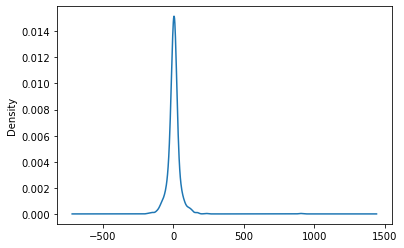

In [32]:
model_arima.resid.plot(kind='kde')

In [28]:
test['Close: Predicted_ARIMA'] = pred

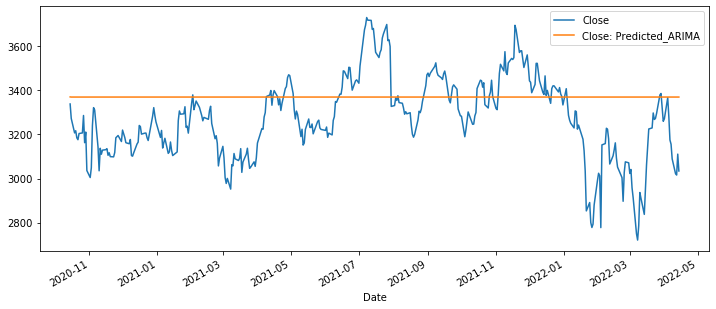

In [29]:
test[['Close', 'Close: Predicted_ARIMA']].plot(figsize=(12,5))

## Metrics to check prediction

In [30]:
from sklearn.metrics import mean_squared_error as mse

rmse = np.sqrt(mse(pred, test['Close']))
print(rmse)

208.2230173466523


In [51]:
#Seasonal 6month differencing
df_amazon['Close: Seasonal 6month Difference']=df_amazon['Close']-df_amazon['Close'].shift(6)

In [52]:
adf_test(df_amazon['Close: Seasonal 6month Difference'].dropna())

ADF Statistics: -8.734834306596676
p- value: 3.1205664268003014e-14
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [49]:
## create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [53]:
model_SARIMA=SARIMAX(train['Close'],order=(1,1,0),seasonal_order=(1,1,0,6))
model_SARIMA_fit=model_SARIMA.fit()

model_SARIMA_fit.summary()

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  882
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 6)   Log Likelihood               -4610.198
Date:                           Sat, 16 Apr 2022   AIC                           9226.397
Time:                                   19:54:57   BIC                           9240.720
Sample:                                        0   HQIC                          9231.876
                                           - 882                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0877      0.025     -3.471      0.001      -0.137      -0.038
ar.S.L6       -0.5404      0.019    -27.780      0.000      -0.578      -0.502
sigma2      2202.4949     55.554     39.646      0.000    2093.612    2311.378
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               986.48
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               6.72   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
pred_start=len(train)
pred_end=len(train)+len(test)-1

In [55]:
pred_sarima = model_SARIMA_fit.predict(start=pred_start, end=pred_end)
residuals_sarima = test['Close']-pred_sarima

pred_sarima.index = df_amazon.index[pred_start:pred_end+1]

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


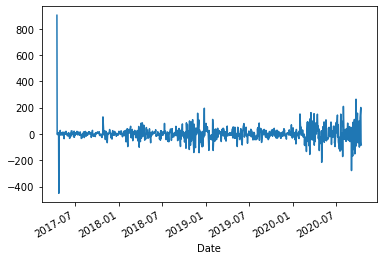

In [56]:
model_SARIMA_fit.resid.plot()

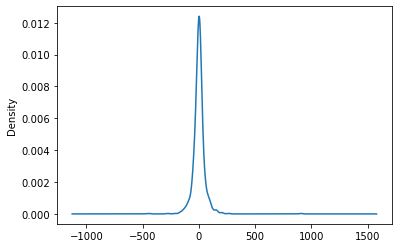

In [57]:
model_SARIMA_fit.resid.plot(kind='kde')

In [58]:
test['Close: Predicted_SARIMA']=pred_sarima

In [59]:
test.head()

,High,Low,Open,Close,Volume,Adj Close,Close: First Difference,Close: Predicted_ARIMA,Close: Predicted_SARIMA
Date,,,,,,,,,
2020-10-15,3355.879883,3280.00000,3292.010010,3338.649902,5223400,3338.649902,-25.060059,3370.697873,3398.693172
2020-10-16,3399.659912,3160.00000,3363.229980,3272.709961,6474400,3272.709961,-65.939941,3370.086875,3397.819866
2020-10-19,3329.000000,3192.73999,3299.610107,3207.209961,5223600,3207.209961,-65.500000,3370.140298,3481.235066
2020-10-20,3266.000000,3192.01001,3222.280029,3217.010010,4509700,3217.010010,9.800049,3370.135627,3501.044771
2020-10-21,3233.879883,3160.00000,3212.500000,3184.939941,4592700,3184.939941,-32.070068,3370.136036,3541.462525


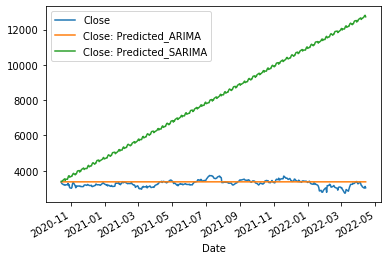

In [60]:
test[['Close','Close: Predicted_ARIMA','Close: Predicted_SARIMA']].plot()